In [1]:
# To allow changes in .py files to be reflected in Notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import signal
from util.stream import Stream, DriftStream
from util.drift_generator import DriftGenerator

### Function to Transform Stream

In [3]:
def transform_stream(stream: Stream, start: float, end: float, drift_scale: float) -> Stream:
    transformed_stream = stream
    dataset = transformed_stream.data
    if start < 1:
        cd1 = round(len(dataset)*start)
        if end < 1:
            cd2 = round(len(dataset)*end)
        if start > 1:
            cd1 = start
        if end > 1:
            cd2 = end
    labels = transformed_stream.anomaly_labels
    # in here, ratio = drift_scale (if ratio < 1 -> inc. freq.)
    val=drift_scale
    d_temp = dataset[cd1:cd2]
    wid_len = int((cd2-cd1)*val)
    d_mod = signal.resample(d_temp, wid_len) 
    l_temp = labels[cd1:cd2]
    l_mod = signal.resample(l_temp, wid_len)
    l_mod = np.round(l_mod) 
    transformed_stream.anomaly_labels = np.concatenate((labels[:cd1], l_mod, labels[cd2:]))
    transformed_stream.anomaly_labels = np.absolute(transformed_stream.anomaly_labels)
    # caution! the length of the stream data attribute is changed here
    transformed_stream.data = np.concatenate((dataset[:cd1], d_mod, dataset[cd2:]))
    transformed_stream.drift_labels = np.zeros((len(transformed_stream.anomaly_labels),1))
    transformed_stream.length = len(transformed_stream.anomaly_labels)
    return transformed_stream




### Creating Stream with Increased Heart Rate

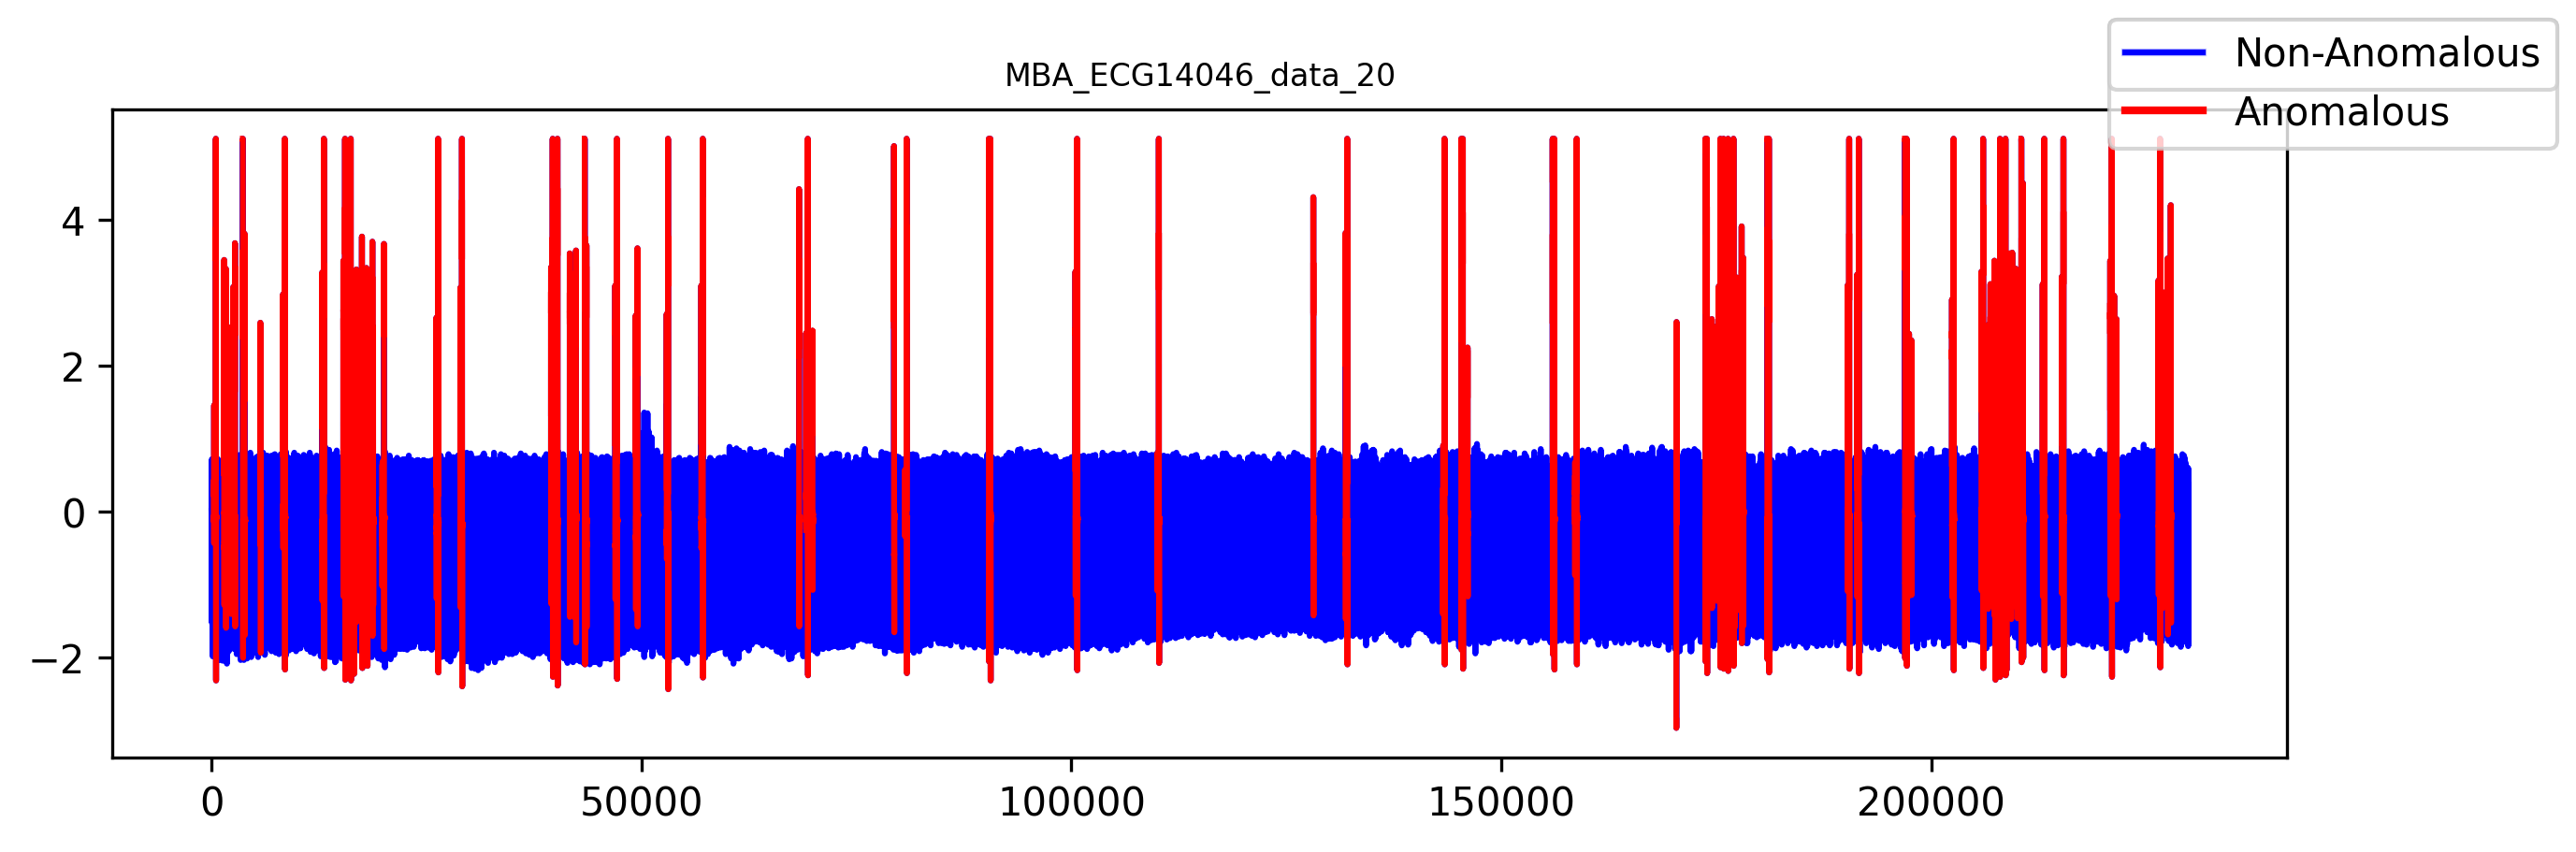

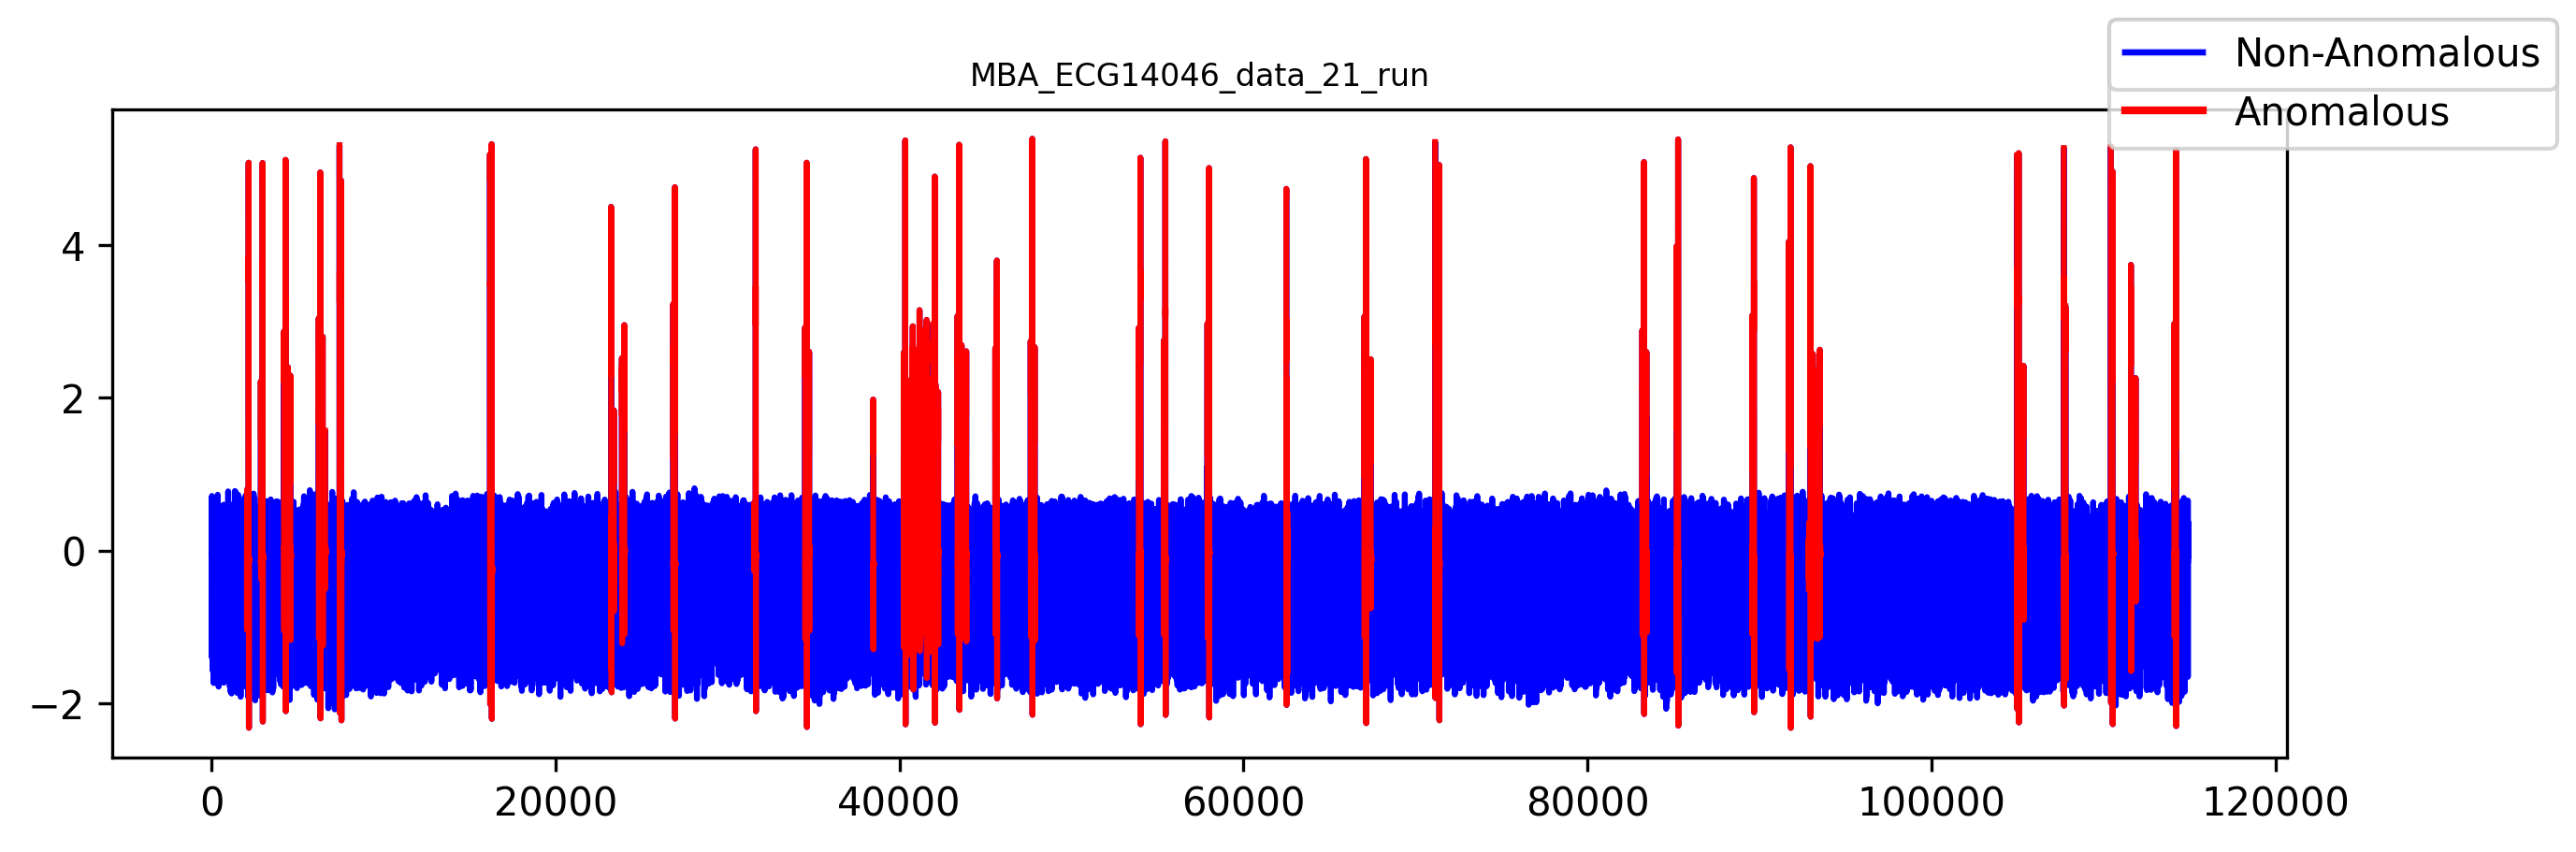

In [4]:
walk_ECG_filepath = '/Users/akankshanehete/Desktop/AnomalyDriftDetection/data/benchmark/ECG/MBA_ECG14046_data_20.arff'
run_ECG_filepath = '/Users/akankshanehete/Desktop/AnomalyDriftDetection/data/benchmark/ECG/MBA_ECG14046_data_21.arff'
walk_ECG = Stream(walk_ECG_filepath)
run_ECG_src = Stream(run_ECG_filepath)
run_ECG = transform_stream(run_ECG_src, 0, run_ECG_src.data.size-1, 0.5)
run_ECG.filename = f"{run_ECG.filename}_run"
walk_ECG.plot()
run_ECG.plot()


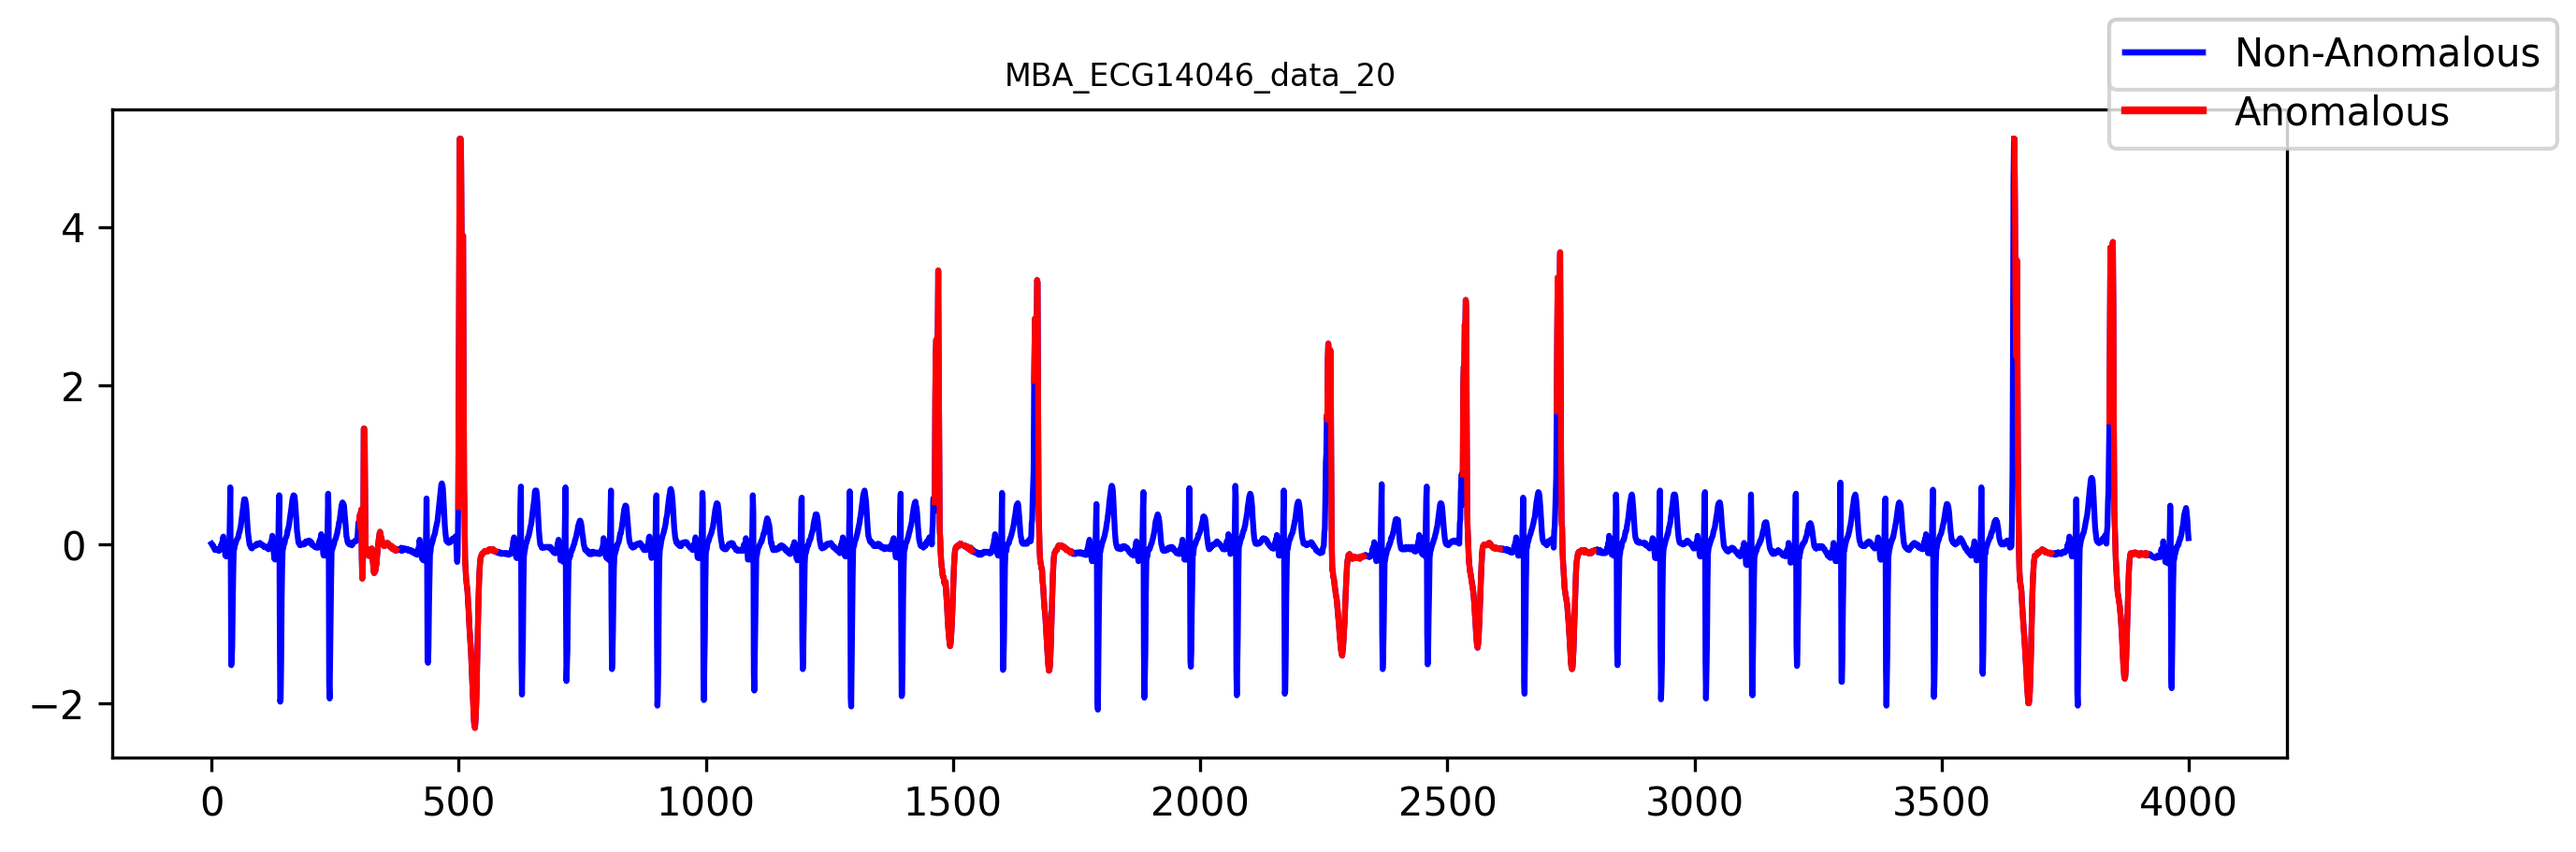

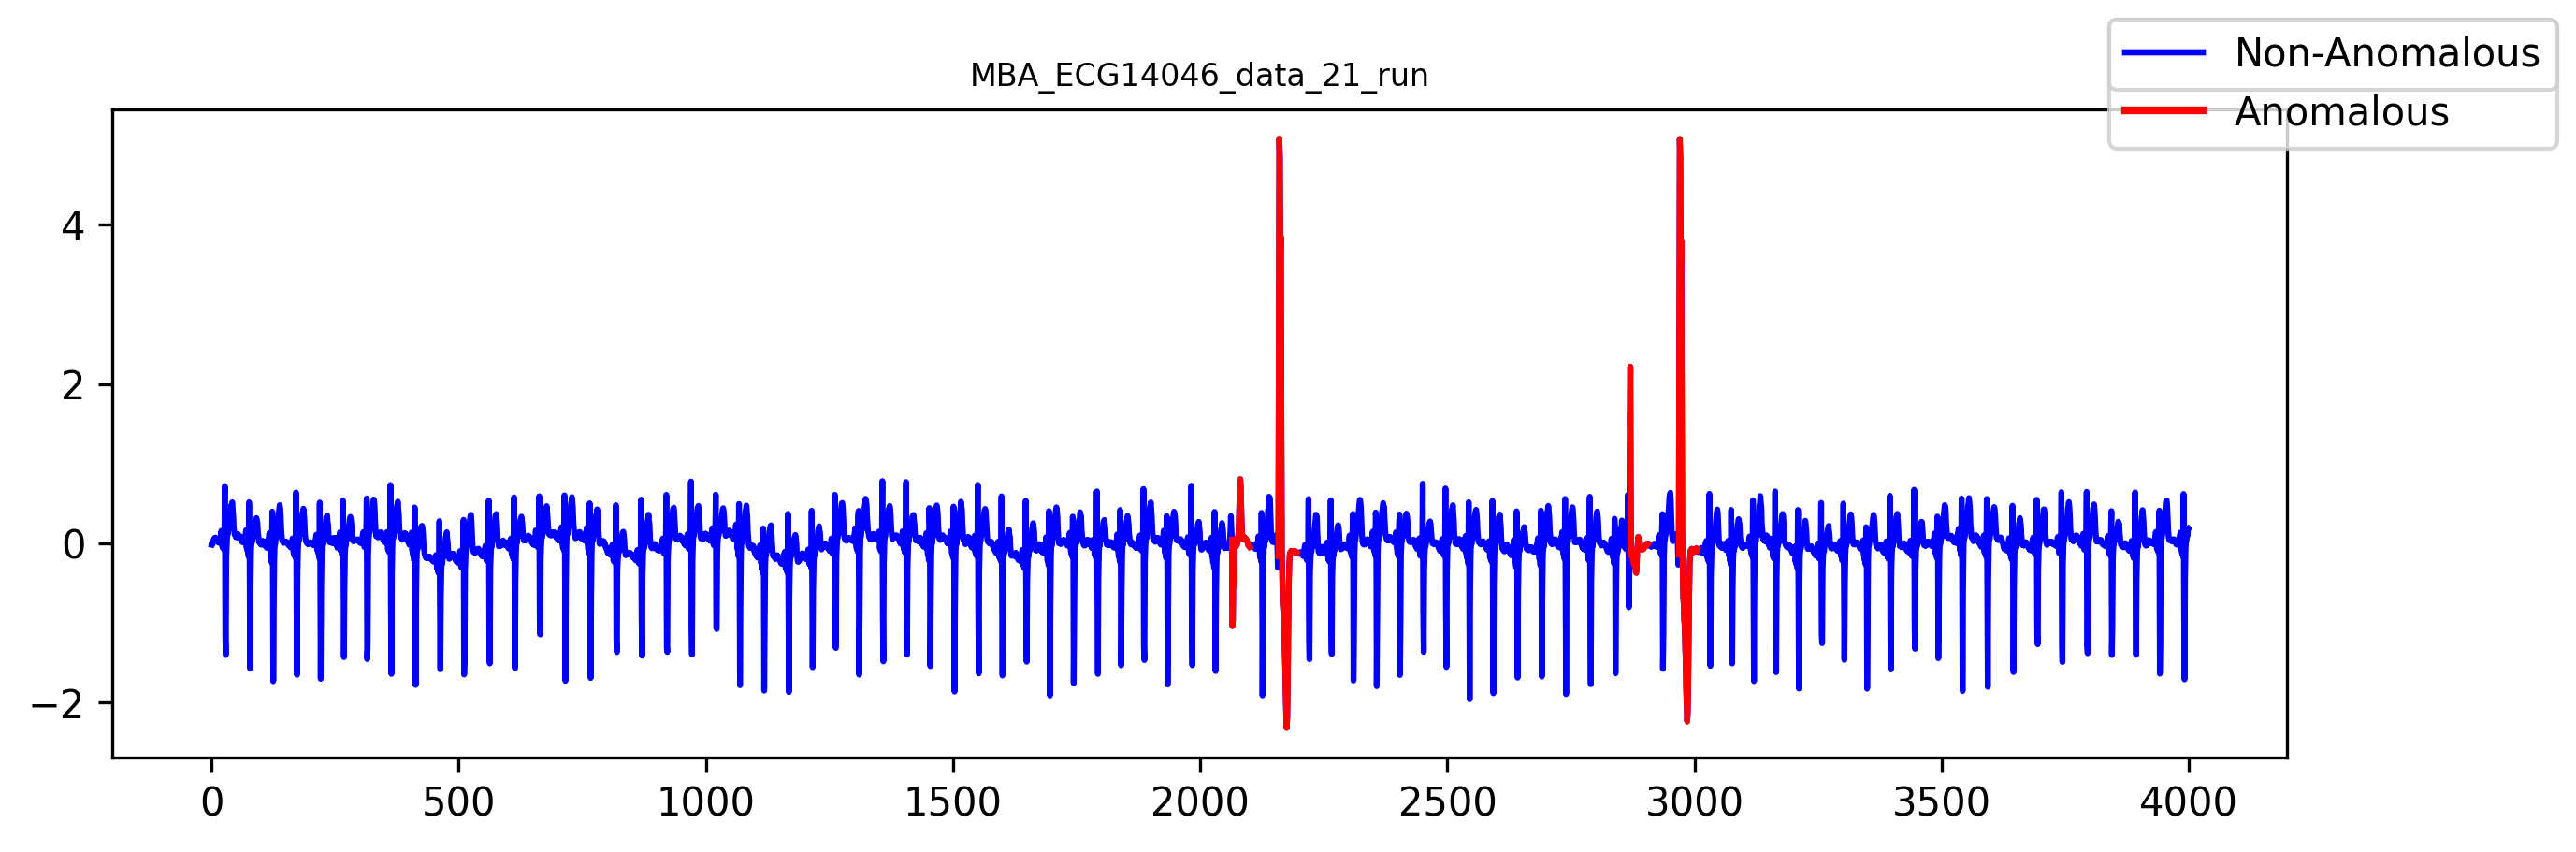

In [5]:
walk_ECG.plot(end=4000)
run_ECG.plot(end=4000)

In [6]:
source_dir = '/Users/akankshanehete/Desktop/AnomalyDriftDetection/data/benchmark/ECG'
run_ECG.to_arff(source_dir)

'MBA_ECG14046_data_21_run.arff'

### Creating drift stream using above streams

In [7]:
drift_dir = '/Users/akankshanehete/Desktop/AnomalyDriftDetection/data/synthetic'
moa_path = '/Users/akankshanehete/Desktop/moa-release-2023.04.0/lib'
source_streams = [walk_ECG, run_ECG]

In [8]:
g = DriftGenerator(source_dir, drift_dir, moa_path, selected_streams=source_streams)

In [9]:
length = run_ECG.length
n_drift = 20
p_drift = 0.35
p_drift_before = 0.5
sub_dir = 'demo'
dataset = 'ECG'
ds = g.run_generate_grad_stream_moa(
    length, 
    p_drift, 
    n_drift,
    p_drift_before, 
    sub_dir,
    dataset,
    mode=0 # 0 for variable drift widths and positions, 1 for uniform
)

Generating splits...
	Getting partitions...
	Getting order of drifts coming before anomaly...
	Getting drift center positions...
	Getting stream file cuts...
Done!
Getting stream file cuts...	Done!
Creating intermediate files...	Done!
Recursively generating MOA command...	Done!
Drift filename:  ECG_grad_p34_n13_b50
Running terminal command...	


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.74s (CPU time)



Stream written to ARFF file /Users/akankshanehete/Desktop/AnomalyDriftDetection/data/synthetic/demo/ECG_grad_p34_n13_b50.arff
Done!
Generating drift labels...	Done!


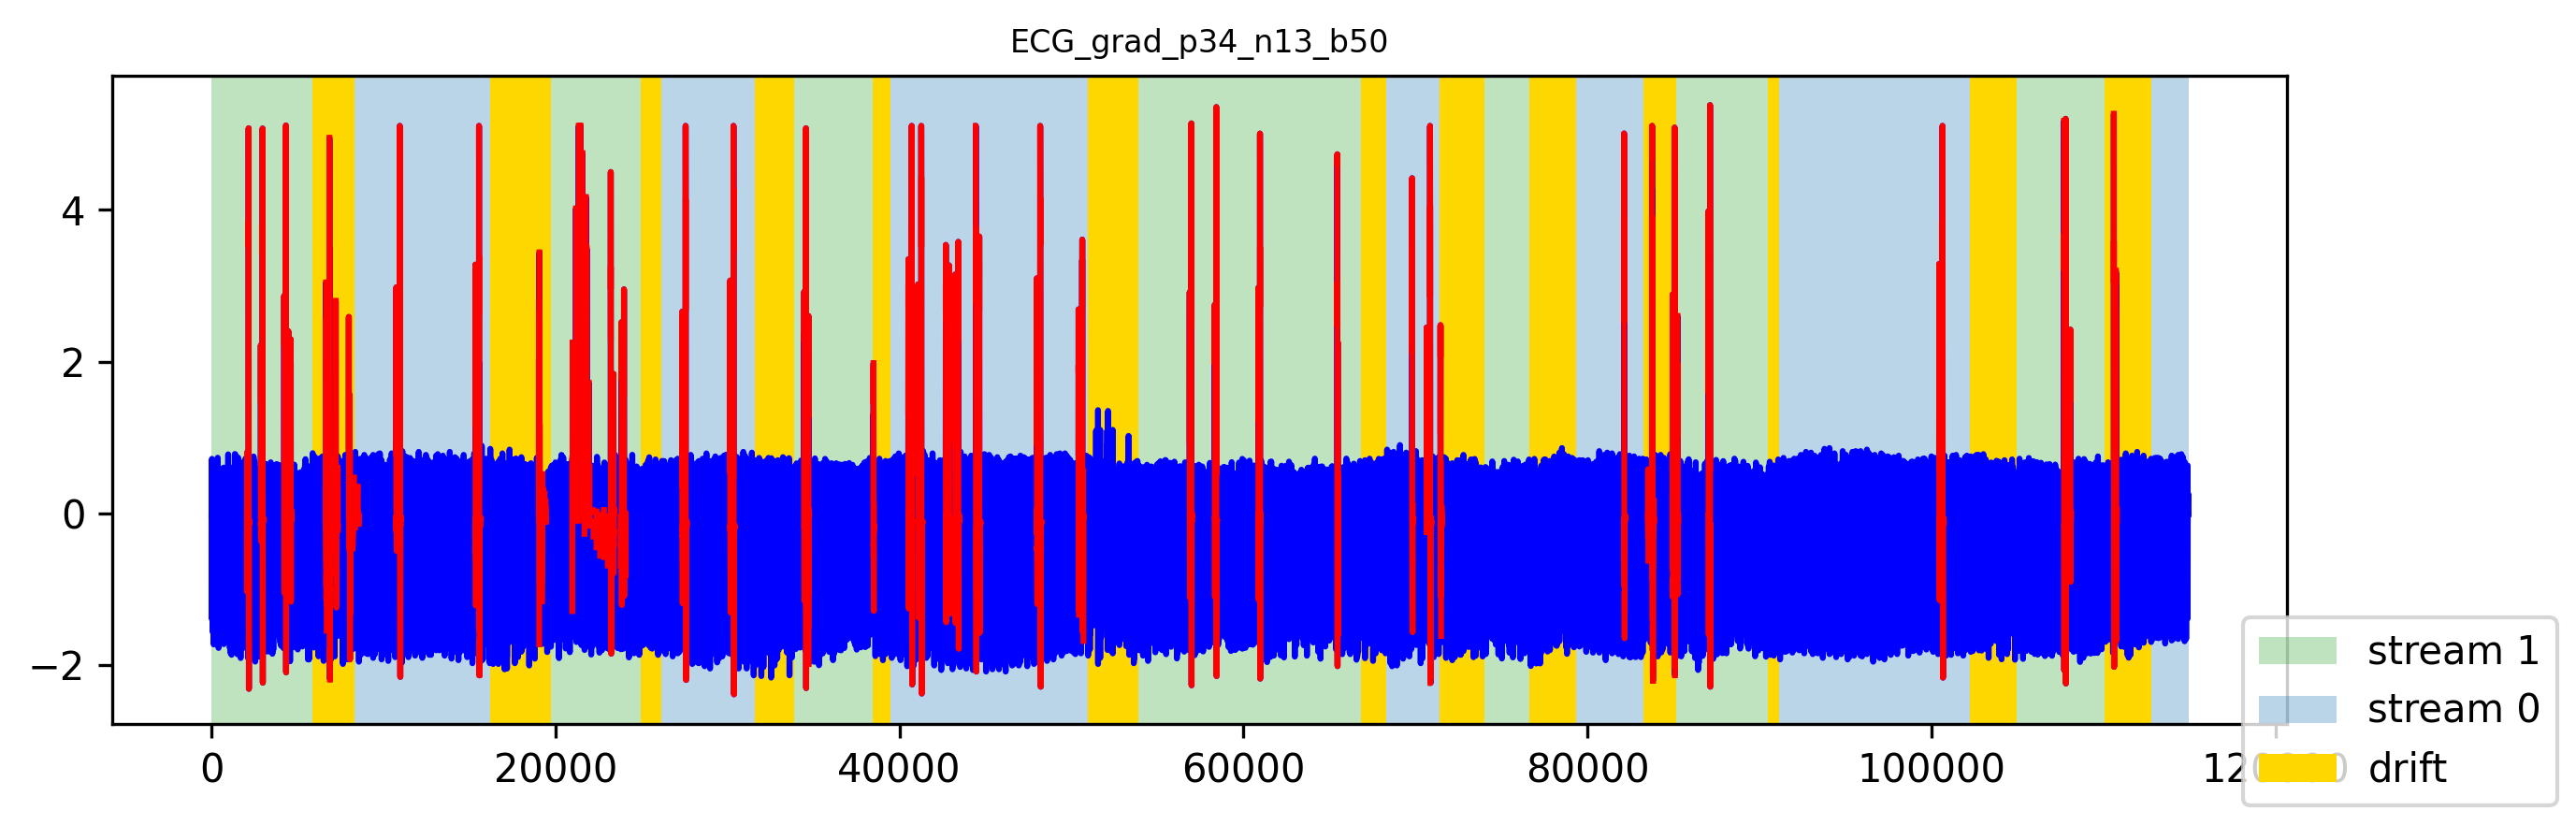

In [10]:
ds.plot_drift()

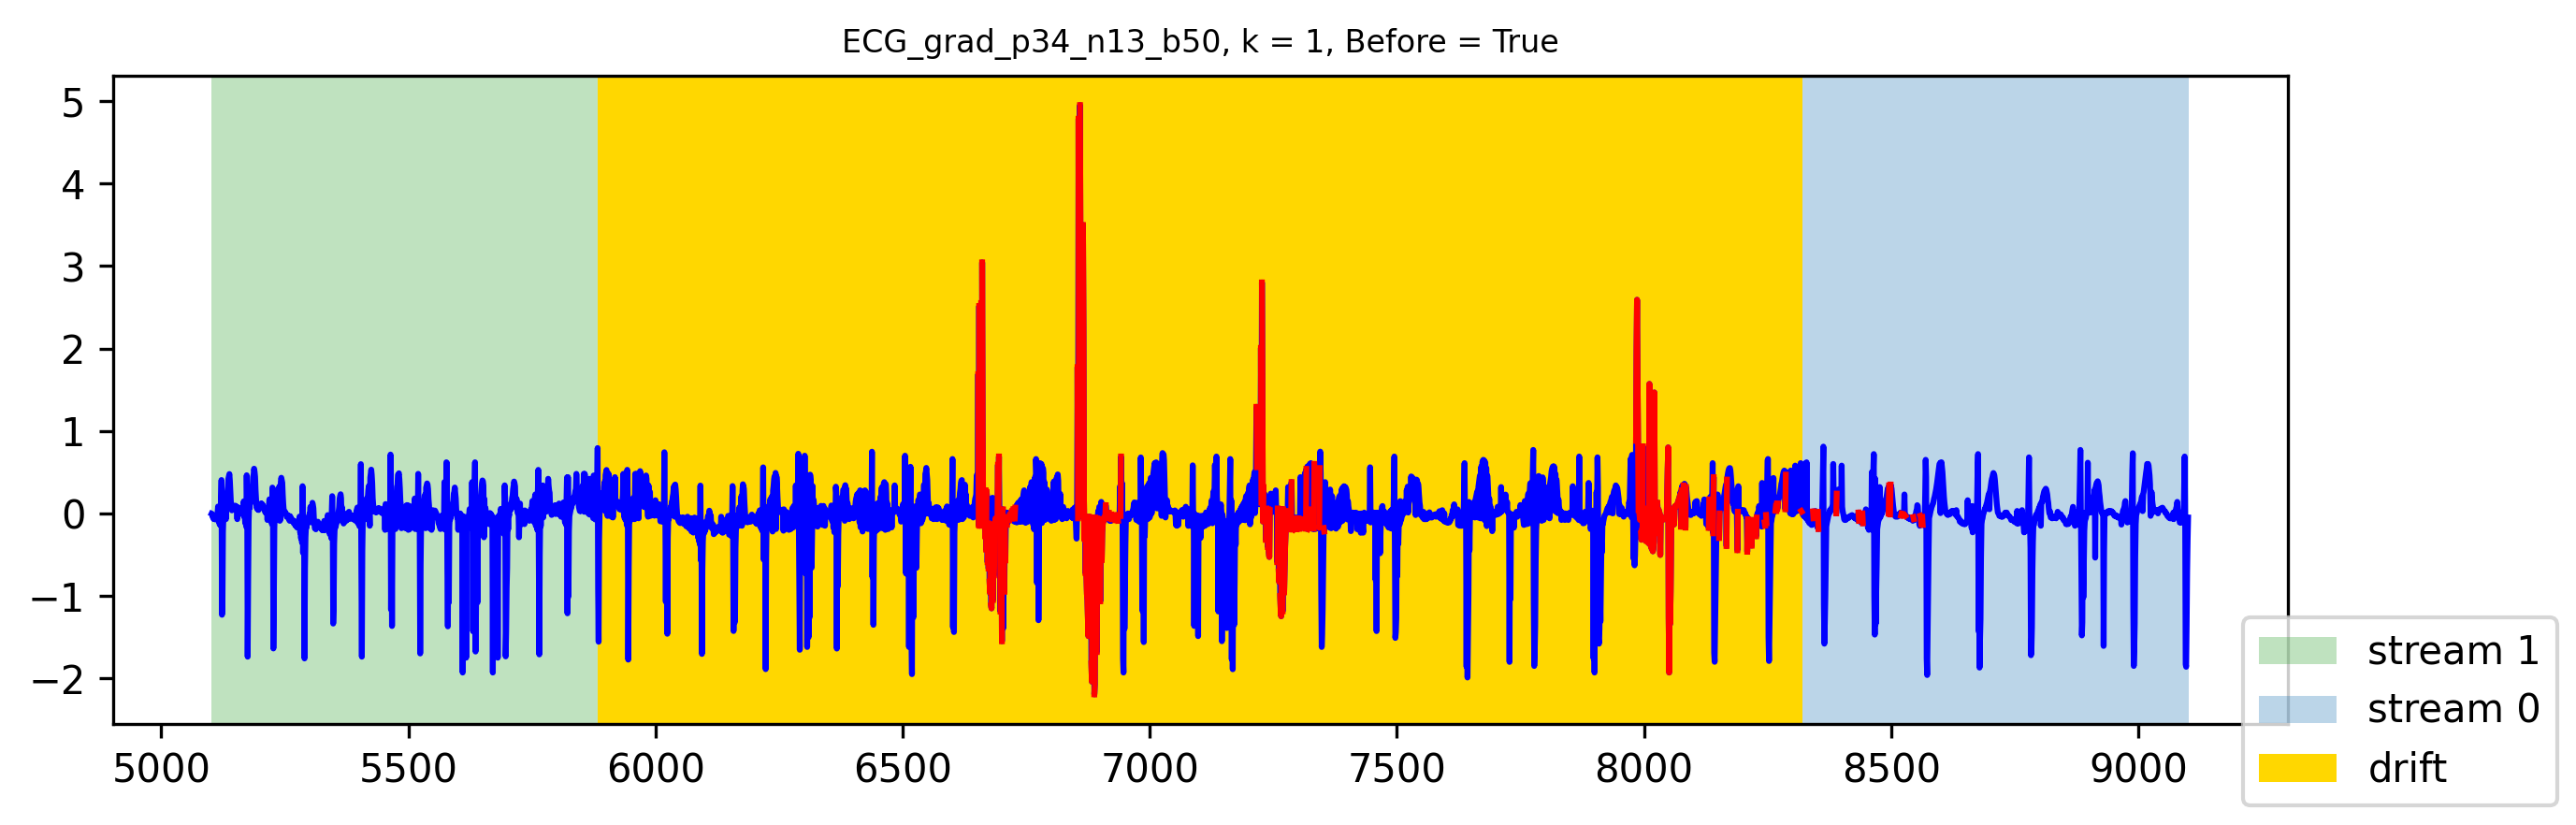

In [11]:
ds.plot_drift_k(k=1, w=2000)

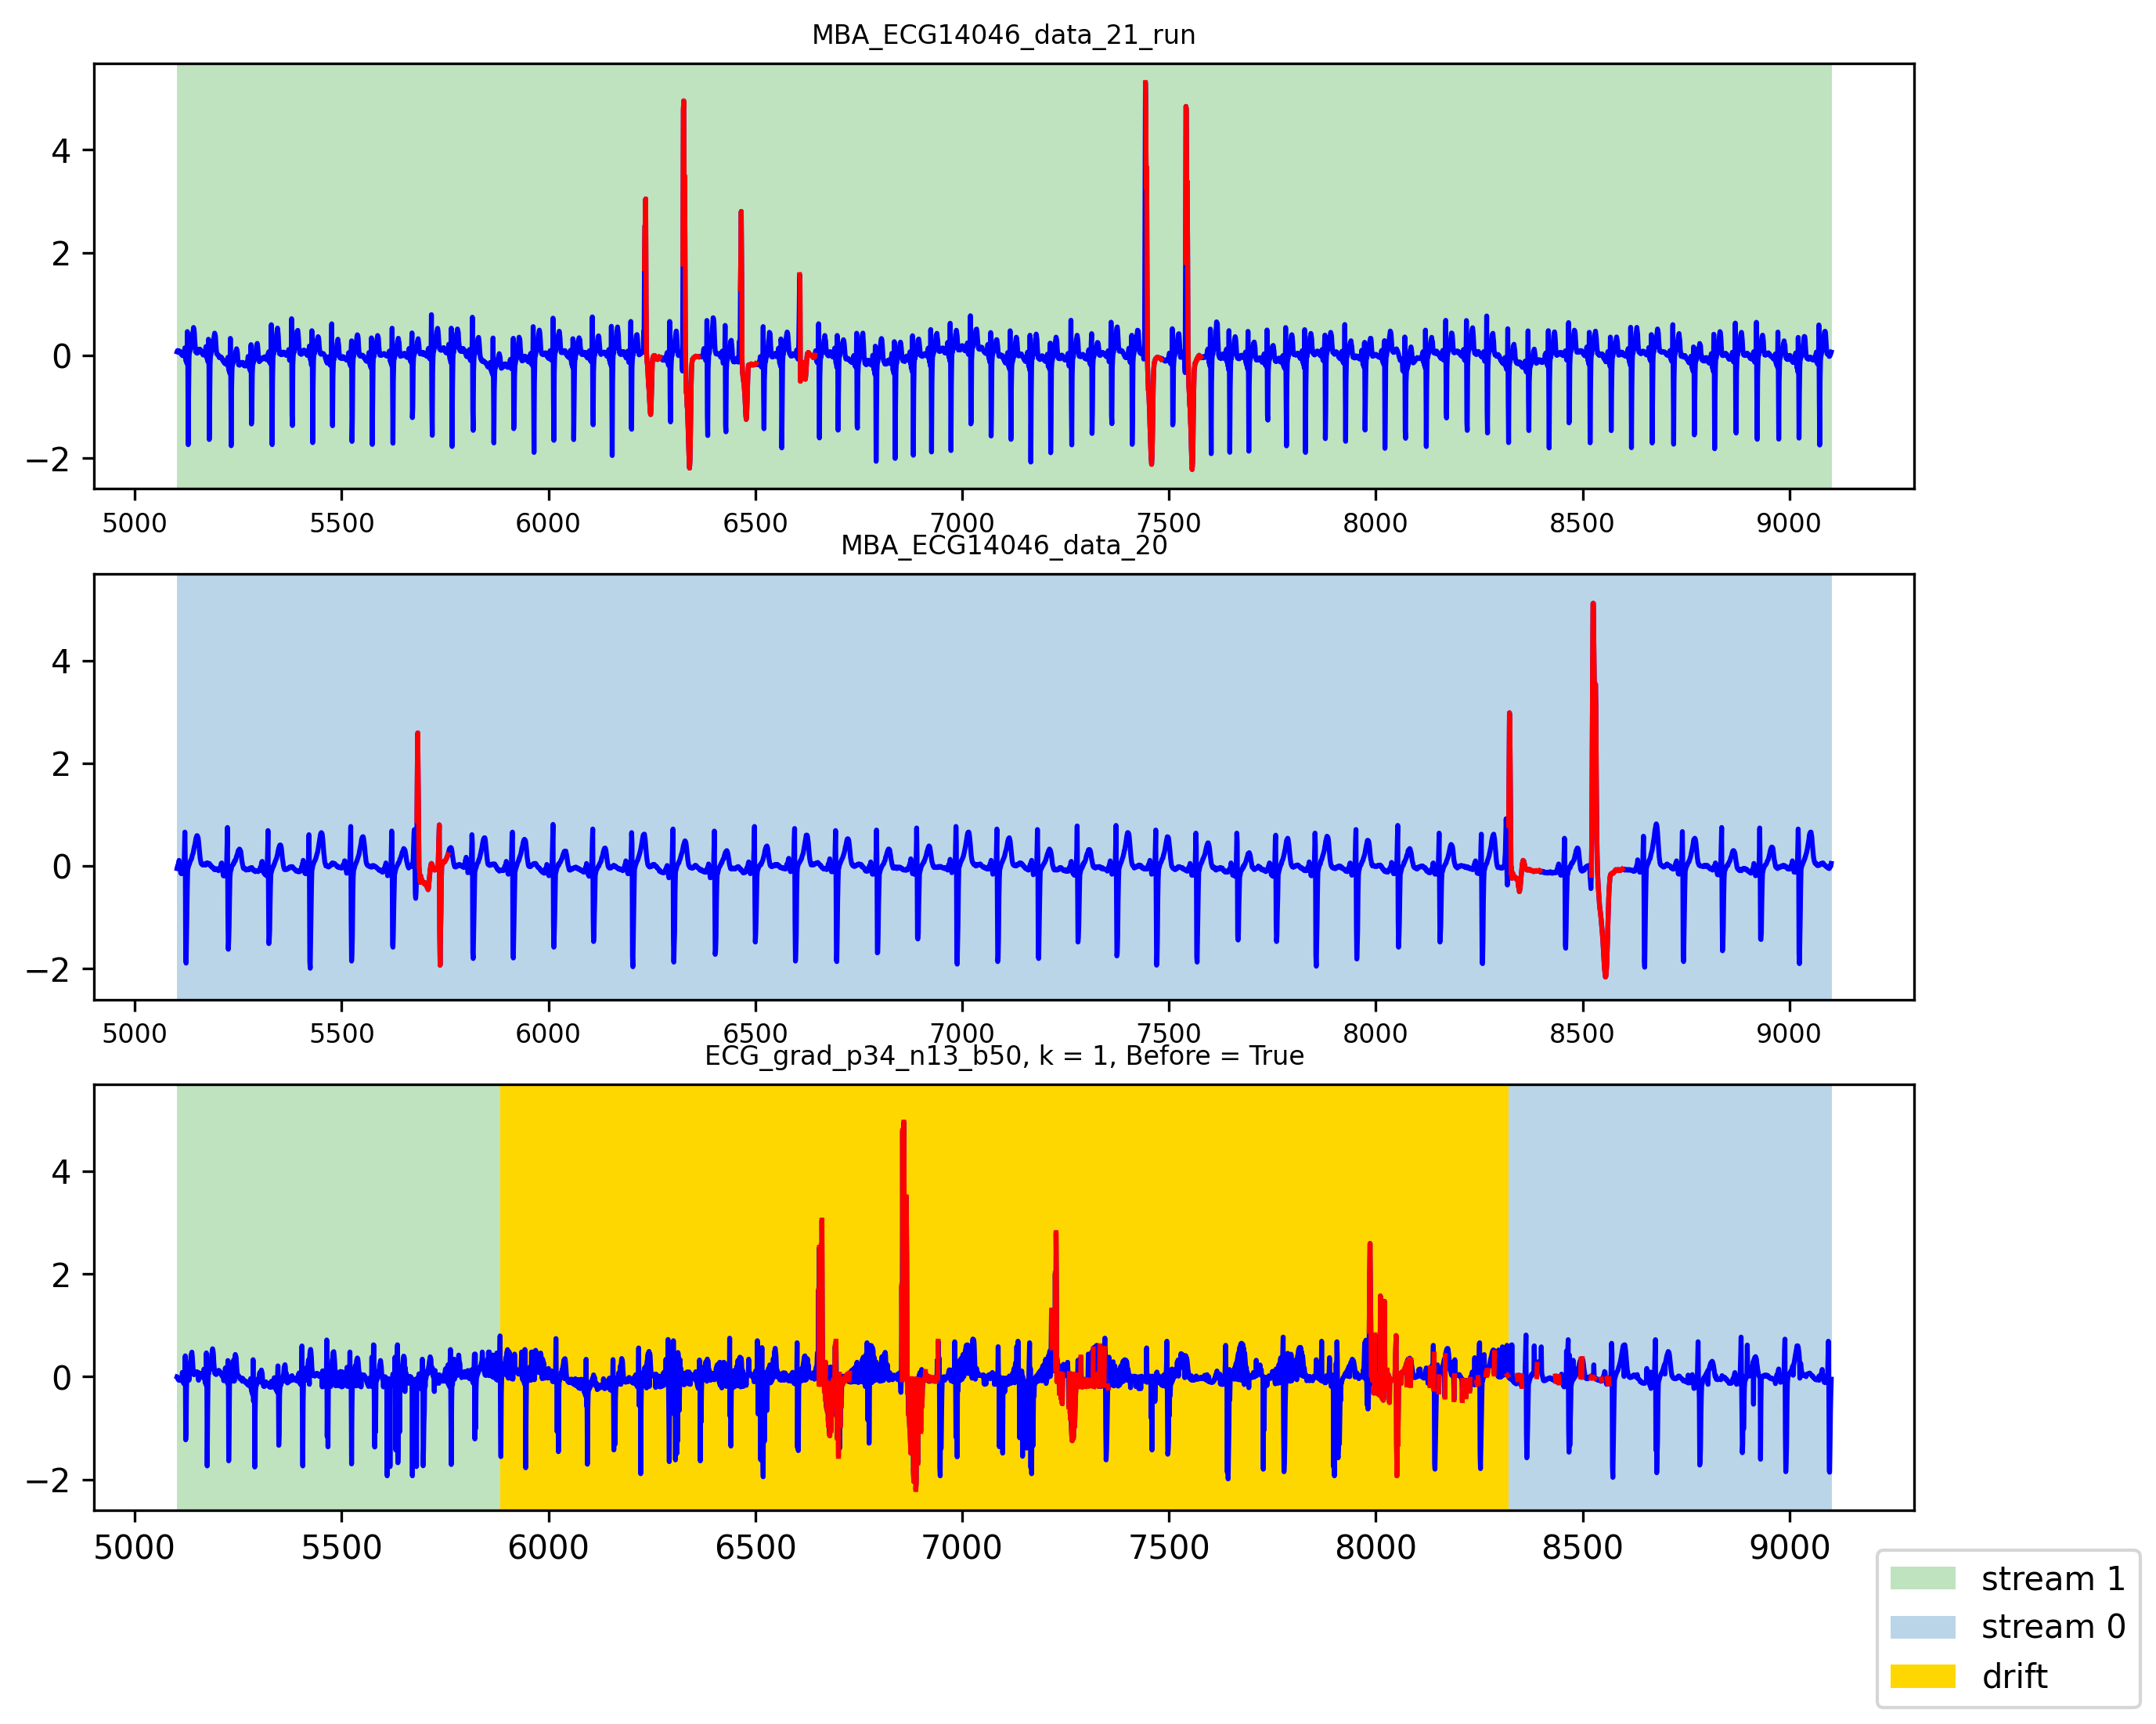

In [12]:
ds.plot_drift_k_with_source(k=1, w=2000)

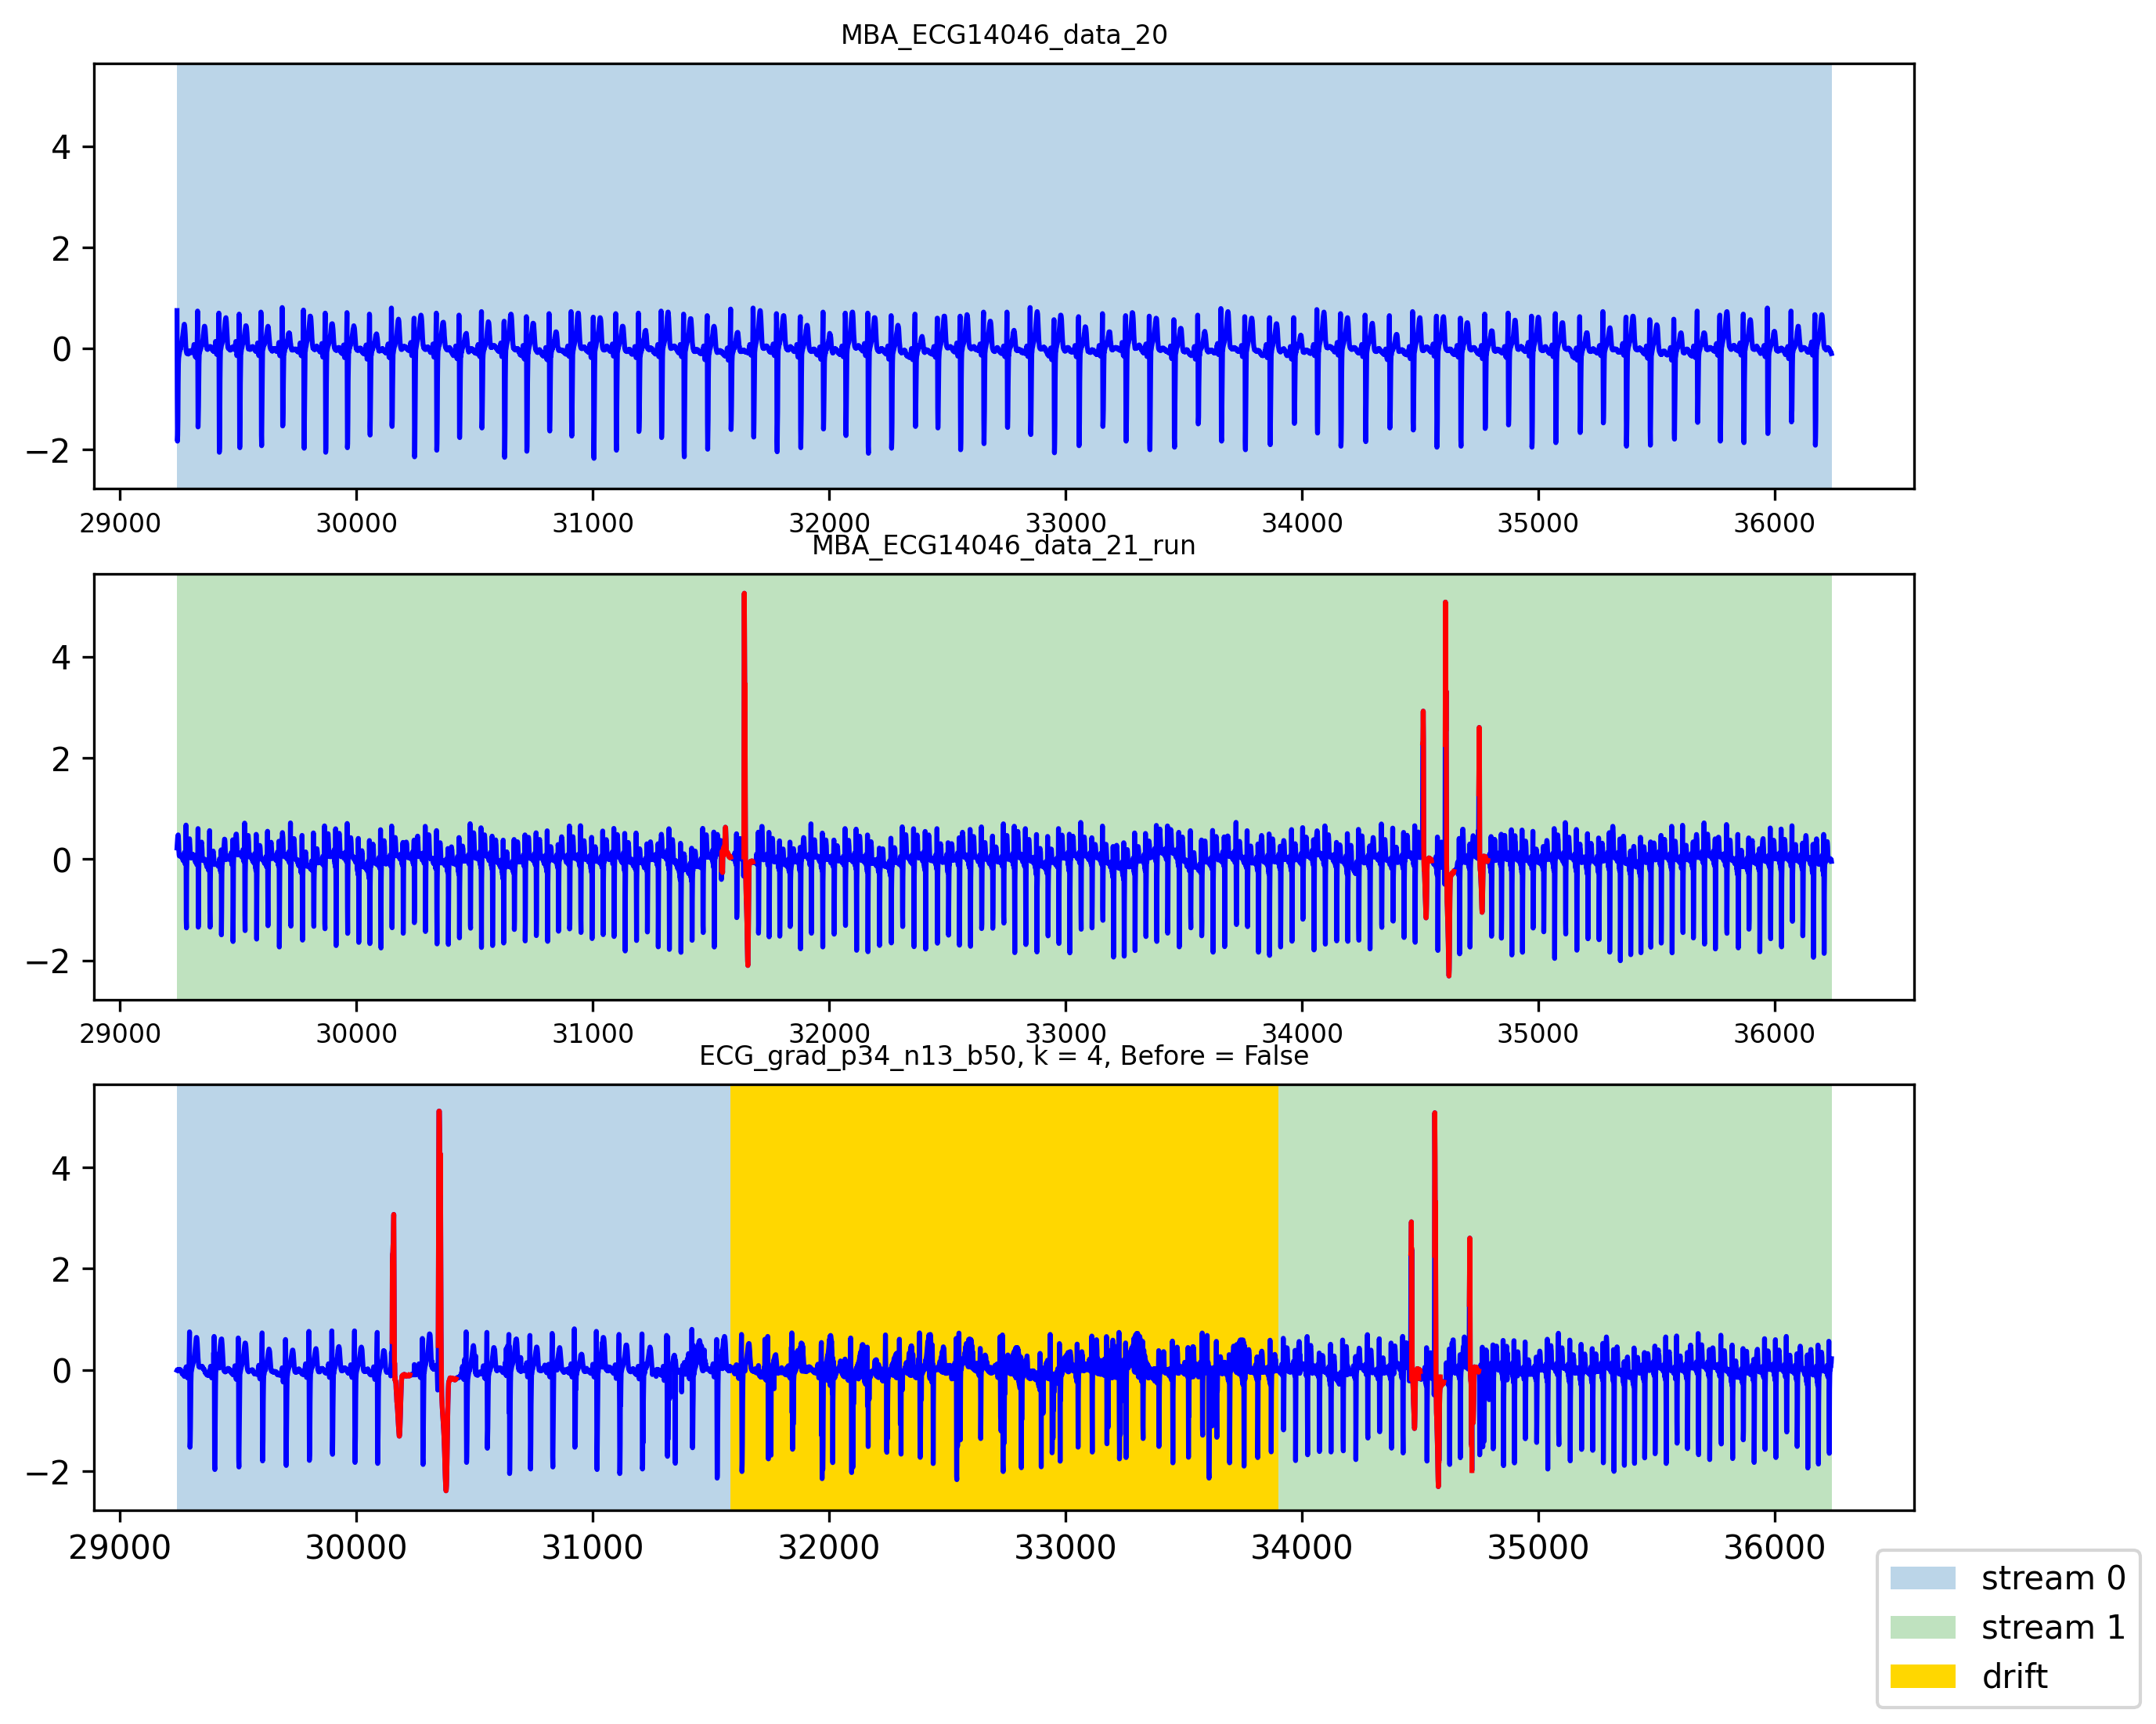

In [13]:
ds.plot_drift_k_with_source(k=4, w=3500)